# Design and Impact of Automated Decision Systems

In [26]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train = df_train[df_train["person_income"] < 1e6] # Remove the really high outlier
df_train = df_train[df_train["person_age"] <= 100] # Remove the really high outlier


In [ ]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


In [61]:
# Separate the classes
defaulted = df_train[df_train['loan_status'] == 1]
not_defaulted = df_train[df_train['loan_status'] == 0]

# Get the smaller class size
n = min(len(defaulted), len(not_defaulted))

# Randomly sample from both classes
defaulted_sample = defaulted.sample(n, random_state=42)
not_defaulted_sample = not_defaulted.sample(n, random_state=42)

# Combine them into one balanced DataFrame
df_train = pd.concat([defaulted_sample, not_defaulted_sample]).sample(frac=1, random_state=42)  # shuffle

# Result: balanced_df is your balanced dataset
print(df_train['loan_status'].value_counts())


loan_status
1    4675
0    4675
Name: count, dtype: int64


In [62]:
df_train = df_train[df_train['person_emp_length'] <= 40]


## Data Visualization

### Figures


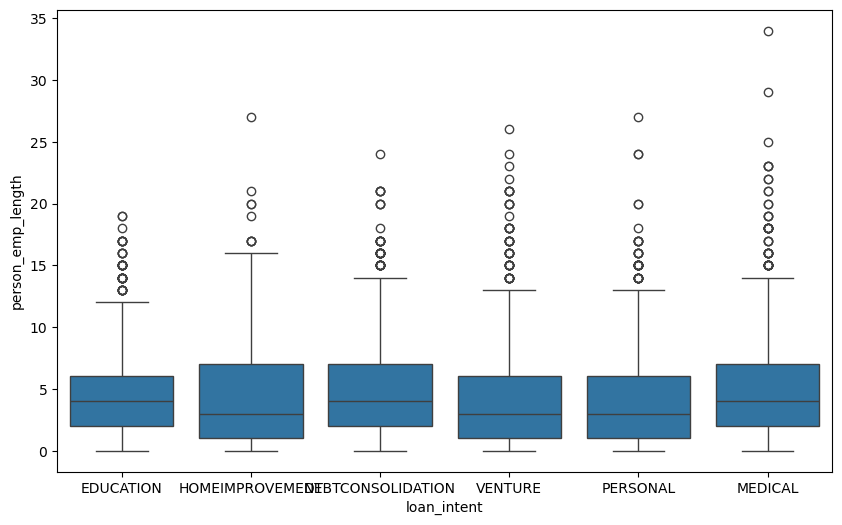

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='loan_intent', y='person_emp_length')
plt.show()


In [64]:
median_income = df_train["person_income"].median()
df_train = df_train[df_train['person_income'] <= (median_income * 2)]

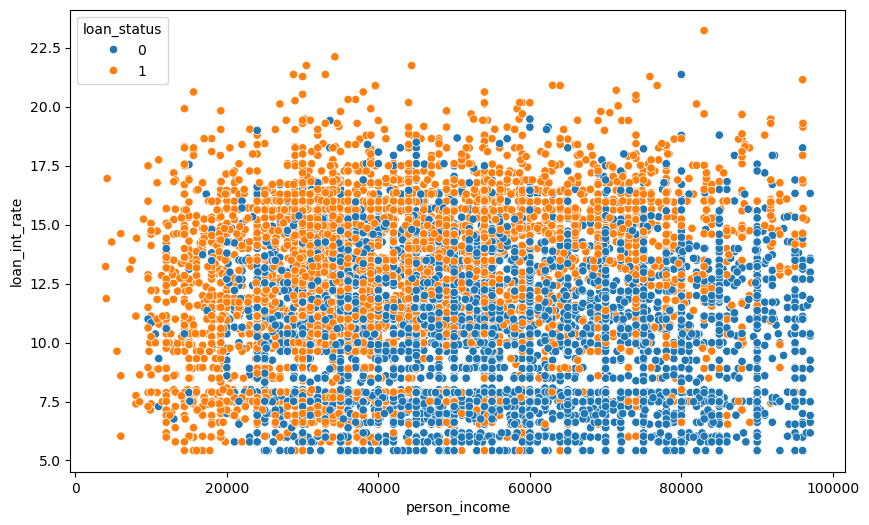

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='person_income', y='loan_int_rate', hue='loan_status')
plt.show()

In [ ]:
summary = df_train[["person_emp_length", "loan_amnt", "loan_grade"]].aggregate([min, max])
summary


/var/folders/t8/bssz0nhj0h94fjkhfd648d280000gn/T/ipykernel_46095/1922889962.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  summary = df_train[["person_emp_length", "loan_amnt", "loan_grade"]].aggregate([min, max])
/var/folders/t8/bssz0nhj0h94fjkhfd648d280000gn/T/ipykernel_46095/1922889962.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  summary = df_train[["person_emp_length", "loan_amnt", "loan_grade"]].aggregate([min, max])


,person_emp_length,loan_amnt,loan_grade
min,0.0,500,A
max,34.0,35000,G


In [67]:
df_train = df_train.dropna()
X = df_train.drop(columns=["loan_status", "loan_grade", "person_home_ownership", "cb_person_default_on_file", "loan_intent"])
y = df_train["loan_status"]


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build Model

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

model = LogisticRegression()

model.fit(X_train, y_train)

w = model.coef_

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Find Threshold

In [70]:
loan_amnt = X_train["loan_amnt"].values
loan_int_rate = X_train["loan_int_rate"].values

# Profit for the bank if the loan is repaid
repaid = loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt
X_train["profit_repaid"] = repaid
# Profit for the bank if the loan is defaulted
default = loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt
X_train["profit_default"] = default


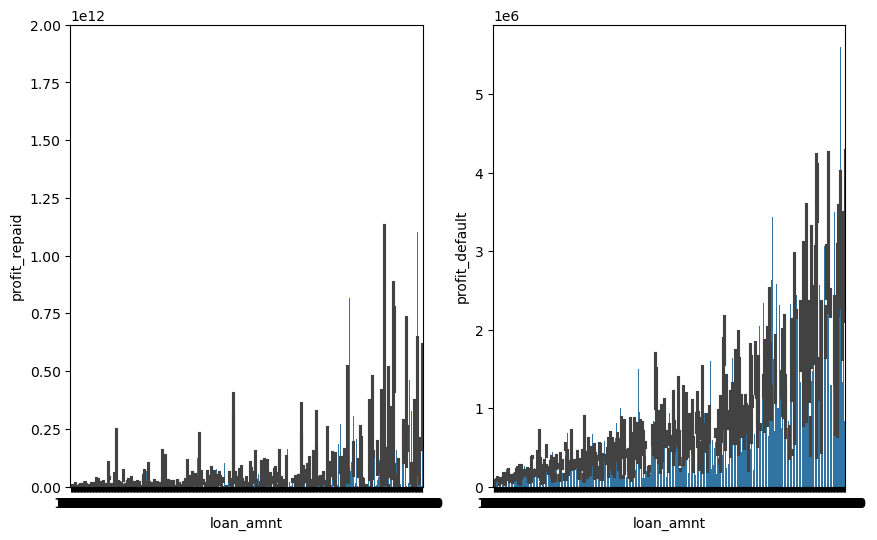

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

plt1 = sns.barplot(X_train, x = "loan_amnt", y = "profit_repaid",  ax=ax[0])
plt2 = sns.barplot(X_train, x = "loan_amnt", y = "profit_default",  ax=ax[1])
plt.show()
